In [1]:
import sys
sys.path.append('../../')
from simCRN.multivariate_reg import read_eq_data_file
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.layers import LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from hyperopt import hp
from hyperopt import rand as hprand
from hyperopt import fmin, tpe, space_eval, Trials
from sklearn.model_selection import cross_val_score

# Baseline model: Linear Model

In [3]:
np.seterr(under='warn') # run twice

{'divide': 'warn', 'over': 'warn', 'under': 'warn', 'invalid': 'warn'}

Reading in the data

In [4]:
Ci_all_array, Am_array, Cmin, Cmax, Ai = read_eq_data_file('../2-2-2-asym-AB-AC.txt')

In [6]:
print(Cmax)

1.5e-06


In [7]:
Am_array.shape

(1000, 2)

Prepare the data

In [5]:
# Splitting into train and test
X_train, X_test, y_train, y_test = train_test_split(Am_array, Ci_all_array, test_size=0.2, random_state=0)

Linear Model

In [6]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [91]:
clf = Ridge(alpha=1.0) # The linear regression model
tt_regressor = TransformedTargetRegressor(regressor=clf, transformer=StandardScaler())
pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

pipeline.fit(X_train, y_train)
y_hat_train = pipeline.predict(X_train)
y_hat_test = pipeline.predict(X_test)

In [92]:
train_mae = mae(y_train, y_hat_train, multioutput='raw_values')
test_mae = mae(y_test, y_hat_test, multioutput='raw_values')

print(f'The MAE on the training data for C₁ is {train_mae[0]:.3}') # 3 significant figures
print(f'The MAE on the training data for C₂ is {train_mae[1]:.3}')
print(f'The MAE on the test data for C₁ is {test_mae[0]:.3}')
print(f'The MAE on the test data for C₂ is {test_mae[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
means = np.mean(Ci_all_array, axis=0)
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, MAE/mean for C₁ is {test_mae[0]/means[0]:.3}')
print(f'For the test data, MAE/mean for C₂ is {test_mae[1]/means[1]:.3}')

The MAE on the training data for C₁ is 8.16e-08
The MAE on the training data for C₂ is 8.65e-08
The MAE on the test data for C₁ is 7.64e-08
The MAE on the test data for C₂ is 8.76e-08

The average value of C₁ is 7.35e-07
The average value of C₂ is 7.57e-07

For the test data, MAE/mean for C₁ is 0.104
For the test data, MAE/mean for C₂ is 0.116


In [93]:
train_mse = mse(y_train, y_hat_train, multioutput='raw_values')
test_mse = mse(y_test, y_hat_test, multioutput='raw_values')
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(f'The RMSE on the training data for C₁ is {train_rmse[0]:.3}') # 3 significant figures
print(f'The RMSE on the training data for C₂ is {train_rmse[1]:.3}')
print(f'The RMSE on the test data for C₁ is {test_rmse[0]:.3}')
print(f'The RMSE on the test data for C₂ is {test_rmse[1]:.3}')

print() # new line

# Contextualizing with the mean of C₁ and C₂
print(f'The average value of C₁ is {means[0]:.3}')
print(f'The average value of C₂ is {means[1]:.3}')

print() # new line

print(f'For the test data, RMSE/mean for C₁ is {test_rmse[0]/means[0]:.3}')
print(f'For the test data, RMSE/mean for C₂ is {test_rmse[1]/means[1]:.3}')

The RMSE on the training data for C₁ is 1e-07
The RMSE on the training data for C₂ is 1.08e-07
The RMSE on the test data for C₁ is 9.04e-08
The RMSE on the test data for C₂ is 1.11e-07

The average value of C₁ is 7.35e-07
The average value of C₂ is 7.57e-07

For the test data, RMSE/mean for C₁ is 0.123
For the test data, RMSE/mean for C₂ is 0.147


In [94]:
train_r2 = r2_score(y_train, y_hat_train, multioutput='raw_values')
test_r2 = r2_score(y_test, y_hat_test, multioutput='raw_values')

print(f'The R² on the training data for C₁ is {train_r2[0]:.3}') # 3 significant figures
print(f'The R² on the training data for C₂ is {train_r2[1]:.3}')
print(f'The R² on the test data for C₁ is {test_r2[0]:.3}')
print(f'The R² on the test data for C₂ is {test_r2[1]:.3}')

The R² on the training data for C₁ is 0.946
The R² on the training data for C₂ is 0.934
The R² on the test data for C₁ is 0.953
The R² on the test data for C₂ is 0.938


# Hyperparameter optimization

In [7]:
reg_type_list = ["Ridge", "Lasso"]
parameter_space =  {"reg_type": hp.choice("reg_type", reg_type_list), # L2 vs L1 regularization type
                    "reg": hp.uniform("reg", 0, 10), # try values between zero (no regularization) and 10 (high regularization)
                    }

In [103]:
# Evaluation function 
# args should be a dict, with keys for reg_type and reg
def model_eval(args):

    '''Take suggested arguments and perform model evaluation'''
    
    if args["reg_type"] == "Ridge":
        model = Ridge(alpha=args["reg"])
    elif args["reg_type"] == "Lasso":
        model = Lasso(alpha=args["reg"])
    else:
        raise Exception("Something has gone wrong!")
    tt_regressor = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())
    pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

    scores = cross_val_score(pipeline, X_train, y=y_train, scoring='neg_mean_squared_error')

    cv_score = np.mean(scores)

    # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
    return -cv_score

In [104]:
print("Start trials") 

trials = Trials()
# use random search instead of TPE because of numerical underflow with TPE
best = fmin(model_eval, parameter_space, algo=hprand.suggest, max_evals=200, trials=trials) 

Start trials
100%|██████████| 200/200 [00:03<00:00, 54.42trial/s, best loss: 1.1033451341226833e-14]


In [105]:
print("Best parameter set: {}".format(best))
print(f"model = {reg_type_list[best['reg_type']]}")
print(f"regularization = {best['reg']}")
print("Best loss from CV: {:.3}".format(trials.best_trial['result']['loss']))
print("Best RMSE loss from CV: {:.3}".format(np.sqrt(trials.best_trial['result']['loss'])))

Best parameter set: {'reg': 0.21701214268038171, 'reg_type': 0}
model = Ridge
regularization = 0.21701214268038171
Best loss from CV: 1.1e-14
Best RMSE loss from CV: 1.05e-07


In [8]:
best = {'reg': 0.21701214268038171, 'reg_type': 0}

# Train Optimized Model

In [9]:
from sklearn.model_selection import cross_validate

In [10]:
def optimized_model_eval(X_train, y_train, X_test, y_test, parameters, reg_type_list):

    '''Take suggested arguments and perform model evaluation'''
    regularization = parameters["reg"]
    if reg_type_list[parameters["reg_type"]] == "Ridge":
        model = Ridge(alpha=regularization)
    elif reg_type_list[parameters["reg_type"]] == "Lasso":
        model = Lasso(alpha=regularization)
    else:
        raise Exception("Something has gone wrong!")
    
    tt_regressor = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())
    pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

    # Train 5 models on random 80/20 test splits of the input data
    scores = cross_validate(pipeline, X_train, y=y_train, scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'], \
                             return_estimator=True)
    
    # Get average validation MSE
    mean_val_mse = -np.mean(scores['test_neg_mean_squared_error'])
    mean_val_mae = -np.mean(scores['test_neg_mean_absolute_error'])
    # Stdev
    std_val_mse = np.std(-scores['test_neg_mean_squared_error'])
    std_val_mae = np.std(-scores['test_neg_mean_absolute_error'])
    
    # Calculate test MSE
    test_mse_arr = np.zeros((5,2))
    test_mae_arr = np.zeros((5,2))
    for i in range(5):
        y_test_pred = scores['estimator'][i].predict(X_test)
        test_mse_arr[i,:] = mse(y_test, y_test_pred, multioutput='raw_values')
        test_mae_arr[i,:] = mae(y_test, y_test_pred, multioutput='raw_values')
    # Average
    mean_test_mse = np.mean(test_mse_arr)
    mean_test_mae = np.mean(test_mae_arr)
    # Stdev
    std_test_mse = np.std(test_mse_arr)
    std_test_mae = np.std(test_mae_arr)

    # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
    return (scores, mean_val_mse, mean_val_mae, std_val_mse, std_val_mae, test_mse_arr, test_mae_arr, \
            mean_test_mse, mean_test_mae, std_test_mse, std_test_mae)

In [12]:
optimized_scores, optimized_val_mse, optimized_val_mae, optimized_std_val_mse, optimized_std_val_mae, \
optimized_test_mse_arr, optimized_test_mae_arr, optimized_mean_test_mse, optimized_mean_test_mae, \
optimized_std_test_mse, optimized_std_test_mae \
= optimized_model_eval(X_train, y_train, X_test, y_test, best, reg_type_list)

optimized_std_val_rmse = np.std(np.sqrt(-optimized_scores['test_neg_mean_squared_error']))
optimized_std_test_rmse = np.std(np.sqrt(optimized_test_mse_arr))

In [13]:
print(f"Optimized average validation MSE: {optimized_val_mse:.3}\t std: {optimized_std_val_mse:.3}")
print(f"Optimized average validation RMSE: {np.sqrt(optimized_val_mse):.3}\t std: {optimized_std_val_rmse:.3}")
print(f"Optimized average validation MAE: {optimized_val_mae:.3}\t std: {optimized_std_val_mae:.3}")

Optimized average validation MSE: 1.1e-14	 std: 9.34e-16
Optimized average validation RMSE: 1.05e-07	 std: 4.44e-09
Optimized average validation MAE: 8.48e-08	 std: 2.31e-09


In [14]:
print(f"Optimized average test MSE: {optimized_mean_test_mse:.3}\t std: {optimized_std_test_mse:.3}")
print(f"Optimized average test RMSE: {np.sqrt(optimized_mean_test_mse):.3}\t std: {optimized_std_test_rmse:.3}")
print(f"Optimized average test MAE: {optimized_mean_test_mae:.3}\t std: {optimized_std_test_mae:.3}")

Optimized average test MSE: 1.03e-14	 std: 2.11e-15
Optimized average test RMSE: 1.01e-07	 std: 1.04e-08
Optimized average test MAE: 8.21e-08	 std: 5.64e-09


In [15]:
print(f"Optimized average validation MSE: {optimized_val_mse}\t std: {optimized_std_val_mse}")
print(f"Optimized average validation RMSE: {np.sqrt(optimized_val_mse)}\t std: {optimized_std_val_rmse}")
print(f"Optimized average validation MAE: {optimized_val_mae}\t std: {optimized_std_val_mae}")
print(f"Optimized average test MSE: {optimized_mean_test_mse}\t std: {optimized_std_test_mse}")
print(f"Optimized average test RMSE: {np.sqrt(optimized_mean_test_mse)}\t std: {optimized_std_test_rmse}")
print(f"Optimized average test MAE: {optimized_mean_test_mae}\t std: {optimized_std_test_mae}")

Optimized average validation MSE: 1.1033451341226833e-14	 std: 9.339629118765328e-16
Optimized average validation RMSE: 1.050402367725189e-07	 std: 4.444033981093617e-09
Optimized average validation MAE: 8.476927001749677e-08	 std: 2.3137069683063955e-09
Optimized average test MSE: 1.0294257896151414e-14	 std: 2.1070163327541232e-15
Optimized average test RMSE: 1.014606223918985e-07	 std: 1.0437536348651418e-08
Optimized average test MAE: 8.213621536765474e-08	 std: 5.636721128715945e-09


# Reducing Dataset Size

In [16]:
def prep_data(X, y, total_size, test_size, random_state):
    # Calculate the size of the reduced data set
    total_frac = total_size/y.shape[0]
    # Reducing the dataset size
    X_train_all, X_test_all, y_train_all, y_test_all = \
    train_test_split(X, y, test_size=1-total_frac, random_state=random_state)
    
    # Splitting into train and test
    X_train, X_test, y_train, y_test = \
    train_test_split(X_train_all, y_train_all, test_size=test_size, random_state=random_state)
    
    return(X_train, X_test, X_test_all, y_train, y_test, y_test_all)

In [17]:
# Reduced data set sizes
data_set_sizes = 1000 * 0.5 ** np.arange(1,5)
print(data_set_sizes)
# Lists to store data and results in
trials_list = []
best_params_list = []
X_train_list = []
X_test_list = []
X_test_all_list = []
y_train_list = []
y_test_list = []
y_test_all_list = []

[500.  250.  125.   62.5]


In [121]:
# Iterate through smaller data set sizes
for data_set_size in data_set_sizes:
    print(f"Data set size: {data_set_size}")
    X_train_sub, X_test_sub, X_test_all, y_train_sub, y_test_sub, y_test_all = \
    prep_data(X_train, y_train, data_set_size, 0.2, 0)
    # Add data sets to lists
    X_train_list.append(X_train_sub)
    X_test_list.append(X_test_sub)
    X_test_all_list.append(X_test_all)
    y_train_list.append(y_train_sub)
    y_test_list.append(y_test_sub)
    y_test_all_list.append(y_test_all)
    def model_eval_data_set(args):

        '''Take suggested arguments and perform model evaluation'''

        if args["reg_type"] == "Ridge":
            model = Ridge(alpha=args["reg"])
        elif args["reg_type"] == "Lasso":
            model = Lasso(alpha=args["reg"])
        else:
            raise Exception("Something has gone wrong!")
        tt_regressor = TransformedTargetRegressor(regressor=model, transformer=StandardScaler())
        pipeline = Pipeline([('x_scaler', StandardScaler()), ('regressor', tt_regressor)])

        scores = cross_val_score(pipeline, X_train, y=y_train, scoring='neg_mean_squared_error')

        cv_score = np.mean(scores)

        # return the negative of the CV score to ensure we maximize the negative MSE by minimizing the loss
        return -cv_score
    # Hyperparameter optimize
    trials = Trials()
    best = fmin(model_eval_data_set, parameter_space, algo=hprand.suggest, max_evals=200, trials=trials)
    trials_list.append(trials)
    best_params_list.append(best)
    print("Best parameter set: {}".format(best))
    print(f"model = {reg_type_list[best['reg_type']]}")
    print(f"regularization = {best['reg']}")

Data set size: 500.0
100%|██████████| 200/200 [00:03<00:00, 55.19trial/s, best loss: 1.1033426871334148e-14]
Best parameter set: {'reg': 0.043655001900984036, 'reg_type': 0}
model = Ridge
regularization = 0.043655001900984036
Data set size: 250.0
100%|██████████| 200/200 [00:03<00:00, 54.90trial/s, best loss: 1.1033432487004022e-14]
Best parameter set: {'reg': 0.10358328030661057, 'reg_type': 0}
model = Ridge
regularization = 0.10358328030661057
Data set size: 125.0
100%|██████████| 200/200 [00:03<00:00, 54.96trial/s, best loss: 1.103296758938035e-14]
Best parameter set: {'reg': 0.009412697089160593, 'reg_type': 1}
model = Lasso
regularization = 0.009412697089160593
Data set size: 62.5
100%|██████████| 200/200 [00:03<00:00, 52.67trial/s, best loss: 1.1033437594515793e-14]
Best parameter set: {'reg': 0.14151493095862056, 'reg_type': 0}
model = Ridge
regularization = 0.14151493095862056


In [18]:
# Iterate through smaller data set sizes
for data_set_size in data_set_sizes:
    print(f"Data set size: {data_set_size}")
    X_train_sub, X_test_sub, X_test_all, y_train_sub, y_test_sub, y_test_all = \
    prep_data(X_train, y_train, data_set_size, 0.2, 0)
    # Add data sets to lists
    X_train_list.append(X_train_sub)
    X_test_list.append(X_test_sub)
    X_test_all_list.append(X_test_all)
    y_train_list.append(y_train_sub)
    y_test_list.append(y_test_sub)
    y_test_all_list.append(y_test_all)

Data set size: 500.0
Data set size: 250.0
Data set size: 125.0
Data set size: 62.5


In [19]:
best_params_list = [{'reg': 0.043655001900984036, 'reg_type': 0},
                    {'reg': 0.10358328030661057, 'reg_type': 0},
                    {'reg': 0.009412697089160593, 'reg_type': 1},
                    {'reg': 0.14151493095862056, 'reg_type': 0}]
best_params_list

[{'reg': 0.043655001900984036, 'reg_type': 0},
 {'reg': 0.10358328030661057, 'reg_type': 0},
 {'reg': 0.009412697089160593, 'reg_type': 1},
 {'reg': 0.14151493095862056, 'reg_type': 0}]

# Train Optimized Models (Reduced Dataset)

In [20]:
mean_val_mse_list = []
mean_val_mae_list = []
std_val_mse_list = []
std_val_rmse_list = []
std_val_mae_list = []
mean_test_mse_list = []
mean_test_mae_list = []
std_test_mse_list = []
std_test_rmse_list = []
std_test_mae_list = []
for i in range(len(data_set_sizes)):
    scores, mean_val_mse, mean_val_mae, std_val_mse, std_val_mae, test_mse_arr, test_mae_arr, mean_test_mse, \
    mean_test_mae, std_test_mse, std_test_mae = \
    optimized_model_eval(X_train_list[i], y_train_list[i], X_test_list[i], y_test_list[i], \
                         best_params_list[i], reg_type_list)
    std_val_rmse = np.std(np.sqrt(-scores['test_neg_mean_squared_error']))
    std_test_rmse = np.std(np.sqrt(test_mse_arr))
    mean_val_mse_list.append(mean_val_mse)
    mean_val_mae_list.append(mean_val_mae)
    std_val_mse_list.append(std_val_mse)
    std_val_rmse_list.append(std_val_rmse)
    std_val_mae_list.append(std_val_mae)
    mean_test_mse_list.append(mean_test_mse)
    mean_test_mae_list.append(mean_test_mae)
    std_test_mse_list.append(std_test_mse)
    std_test_rmse_list.append(std_test_rmse)
    std_test_mae_list.append(std_test_mae)

In [21]:
print("Mean validation MSE list")
print(mean_val_mse_list)
print("Std validation MSE list")
print(std_val_mse_list)
print("Mean validation MAE list")
print(mean_val_mae_list)
print("Std validation MAE list")
print(std_val_mae_list)

Mean validation MSE list
[1.0825667665573943e-14, 9.038901062456411e-15, 1.0664049225684466e-14, 8.935420435438092e-15]
Std validation MSE list
[6.332098706994491e-16, 2.002122079414764e-15, 2.4709701012248012e-15, 5.035916944841201e-15]
Mean validation MAE list
[8.32741822859363e-08, 7.509331563643028e-08, 8.002196913290838e-08, 6.920846010745297e-08]
Std validation MAE list
[3.3789781767393152e-09, 6.013637066287488e-09, 7.869799169894126e-09, 1.6129757230535278e-08]


In [22]:
for i in range(len(data_set_sizes)):
    print(f"Data set size: {data_set_sizes[i]}")
    print(f"Optimized average validation MSE: {mean_val_mse_list[i]:.3}\t std: {std_val_mse_list[i]:.3}")
    print(f"Optimized average validation RMSE: {np.sqrt(mean_val_mse_list[i]):.3}\t std: {std_val_rmse_list[i]:.3}")
    print(f"Optimized average validation MAE: {mean_val_mae_list[i]:.3}\t std: {std_val_mae_list[i]:.3}")

Data set size: 500.0
Optimized average validation MSE: 1.08e-14	 std: 6.33e-16
Optimized average validation RMSE: 1.04e-07	 std: 3e-09
Optimized average validation MAE: 8.33e-08	 std: 3.38e-09
Data set size: 250.0
Optimized average validation MSE: 9.04e-15	 std: 2e-15
Optimized average validation RMSE: 9.51e-08	 std: 9.98e-09
Optimized average validation MAE: 7.51e-08	 std: 6.01e-09
Data set size: 125.0
Optimized average validation MSE: 1.07e-14	 std: 2.47e-15
Optimized average validation RMSE: 1.03e-07	 std: 1.24e-08
Optimized average validation MAE: 8e-08	 std: 7.87e-09
Data set size: 62.5
Optimized average validation MSE: 8.94e-15	 std: 5.04e-15
Optimized average validation RMSE: 9.45e-08	 std: 2.32e-08
Optimized average validation MAE: 6.92e-08	 std: 1.61e-08


In [24]:
print("Mean test MSE list")
print(mean_test_mse_list)
print("Std test MSE list")
print(std_test_mse_list)
print("Mean test MAE list")
print(mean_test_mae_list)
print("Std test MAE list")
print(std_test_mae_list)

Mean test MSE list
[1.0102535828044288e-14, 1.4079912289131906e-14, 8.328548020035933e-15, 1.0052987817173887e-14]
Std test MSE list
[7.163038243911507e-16, 2.9776153189135785e-15, 1.5956767597833712e-15, 3.2484384232626284e-15]
Mean test MAE list
[8.096272678989943e-08, 8.810025170522505e-08, 7.463692968557702e-08, 7.315183457009429e-08]
Std test MAE list
[1.6550111248369507e-09, 6.454589380167687e-09, 2.1791815525614984e-09, 4.269813705556364e-09]


In [25]:
for i in range(len(data_set_sizes)):
    print(f"Data set size: {data_set_sizes[i]}")
    print(f"Optimized average test MSE: {mean_test_mse_list[i]:.3}\t std: {std_test_mse_list[i]:.3}")
    print(f"Optimized average test RMSE: {np.sqrt(mean_test_mse_list[i]):.3}\t std: {std_test_rmse_list[i]:.3}")
    print(f"Optimized average test MAE: {mean_test_mae_list[i]:.3}\t std: {std_test_mae_list[i]:.3}")

Data set size: 500.0
Optimized average test MSE: 1.01e-14	 std: 7.16e-16
Optimized average test RMSE: 1.01e-07	 std: 3.57e-09
Optimized average test MAE: 8.1e-08	 std: 1.66e-09
Data set size: 250.0
Optimized average test MSE: 1.41e-14	 std: 2.98e-15
Optimized average test RMSE: 1.19e-07	 std: 1.25e-08
Optimized average test MAE: 8.81e-08	 std: 6.45e-09
Data set size: 125.0
Optimized average test MSE: 8.33e-15	 std: 1.6e-15
Optimized average test RMSE: 9.13e-08	 std: 8.79e-09
Optimized average test MAE: 7.46e-08	 std: 2.18e-09
Data set size: 62.5
Optimized average test MSE: 1.01e-14	 std: 3.25e-15
Optimized average test RMSE: 1e-07	 std: 1.64e-08
Optimized average test MAE: 7.32e-08	 std: 4.27e-09


# Plots 

In [26]:
plt.rcParams.update({'font.size': 16})
plot_data_set_sizes = 1000 * 0.5 ** np.arange(0,5)
# mean_val_mse_list.insert(0, optimized_val_mse)
# mean_val_mae_list.insert(0, optimized_val_mae)
# mean_test_mse_list.insert(0, optimized_mean_test_mse)
# mean_test_mae_list.insert(0, optimized_mean_test_mae)
# std_val_mse_list.insert(0, optimized_std_val_mse)
# std_val_rmse_list.insert(0, optimized_std_val_rmse)
# std_val_mae_list.insert(0, optimized_std_val_mae)
# std_test_mse_list.insert(0, optimized_std_test_mse)
# std_test_rmse_list.insert(0, optimized_std_test_rmse)
# std_test_mae_list.insert(0, optimized_std_test_mae)

print("Mean Validation MSE")
print(mean_val_mse_list)
print("Std Validation MSE")
print(std_val_mse_list)
print("Mean Validation RMSE")
print(np.sqrt(mean_val_mse_list))
print("Std Validation RMSE")
print(std_val_rmse_list)
print("Mean Validation MAE")
print(mean_val_mae_list)
print("Std Validation MAE")
print(std_val_mae_list)
print("Mean Test MSE")
print(mean_test_mse_list)
print("Std Test MSE")
print(std_test_mse_list)
print("Mean Test RMSE")
print(np.sqrt(mean_test_mse_list))
print("Std Test RMSE")
print(std_test_rmse_list)
print("Mean Test MAE")
print(mean_test_mae_list)
print("Std Test MAE")
print(std_test_mae_list)

Mean Validation MSE
[1.1033451341226833e-14, 1.0825667665573943e-14, 9.038901062456411e-15, 1.0664049225684466e-14, 8.935420435438092e-15]
Std Validation MSE
[9.339629118765328e-16, 6.332098706994491e-16, 2.002122079414764e-15, 2.4709701012248012e-15, 5.035916944841201e-15]
Mean Validation RMSE
[1.05040237e-07 1.04046469e-07 9.50731353e-08 1.03266883e-07
 9.45273528e-08]
Std Validation RMSE
[4.444033981093617e-09, 2.9951750022623084e-09, 9.979666863051874e-09, 1.2380381541302805e-08, 2.3236975059456148e-08]
Mean Validation MAE
[8.476927001749677e-08, 8.32741822859363e-08, 7.509331563643028e-08, 8.002196913290838e-08, 6.920846010745297e-08]
Std Validation MAE
[2.3137069683063955e-09, 3.3789781767393152e-09, 6.013637066287488e-09, 7.869799169894126e-09, 1.6129757230535278e-08]
Mean Test MSE
[1.0294257896151414e-14, 1.0102535828044288e-14, 1.4079912289131906e-14, 8.328548020035933e-15, 1.0052987817173887e-14]
Std Test MSE
[2.1070163327541232e-15, 7.163038243911507e-16, 2.9776153189135785e

In [27]:
case = "2-2-2 Case 1"
save_name = "lm_2-2-2_asym"

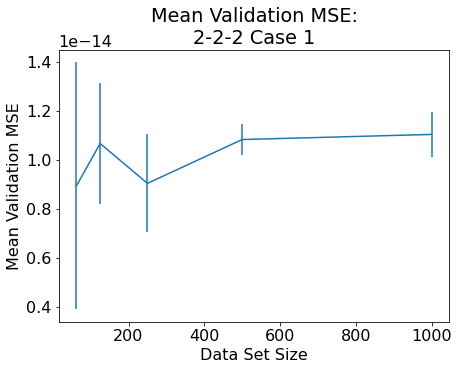

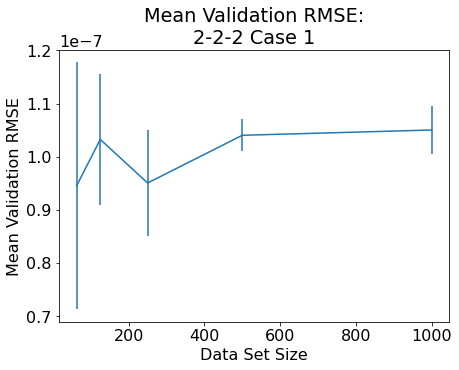

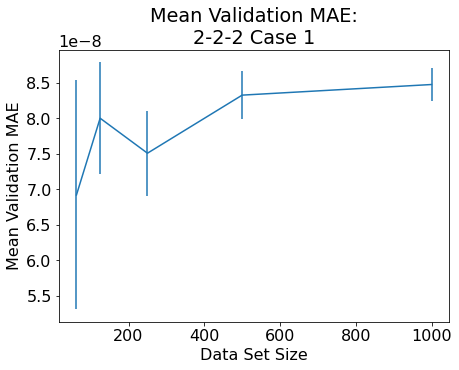

In [28]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.errorbar(plot_data_set_sizes, mean_val_mse_list,yerr=std_val_mse_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Validation MSE")
plt.title(f"Mean Validation MSE:\n{case}")
plt.savefig(f"{save_name}_val_mse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.errorbar(plot_data_set_sizes, np.sqrt(mean_val_mse_list),yerr=std_val_rmse_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Validation RMSE")
plt.title(f"Mean Validation RMSE:\n{case}")
plt.savefig(f"{save_name}_val_rmse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.errorbar(plot_data_set_sizes, mean_val_mae_list,yerr=std_val_mae_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Validation MAE")
plt.title(f"Mean Validation MAE:\n{case}")
plt.savefig(f"{save_name}_val_mae_vs_data.png")

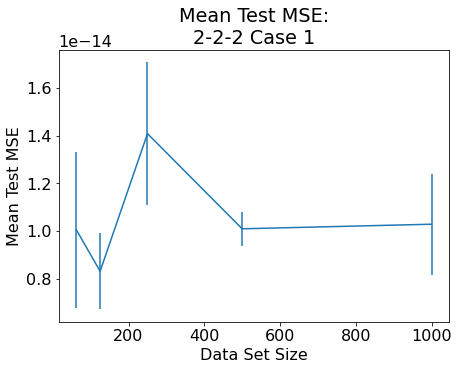

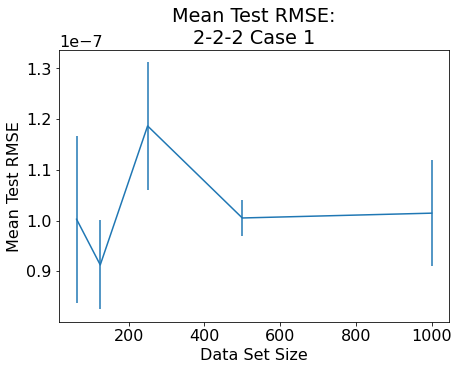

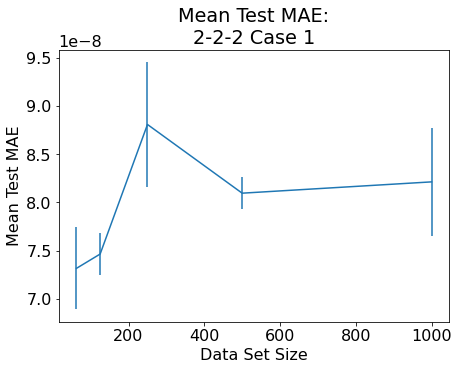

In [29]:
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.errorbar(plot_data_set_sizes, mean_test_mse_list,yerr=std_test_mse_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Test MSE")
plt.title(f"Mean Test MSE:\n{case}")
plt.savefig(f"{save_name}_test_mse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.errorbar(plot_data_set_sizes, np.sqrt(mean_test_mse_list),yerr=std_test_rmse_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Test RMSE")
plt.title(f"Mean Test RMSE:\n{case}")
plt.savefig(f"{save_name}_test_rmse_vs_data.png")
fig, ax = plt.subplots(1,1,figsize=(7,5))
plt.errorbar(plot_data_set_sizes, mean_test_mae_list,yerr=std_test_mae_list)
plt.xlabel("Data Set Size")
plt.ylabel("Mean Test MAE")
plt.title(f"Mean Test MAE:\n{case}")
plt.savefig(f"{save_name}_test_mae_vs_data.png")